In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
tf.random.set_seed(11)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/N.csv')
df1.head()
df2 = pd.read_csv('/content/drive/My Drive/F.csv')
df2.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,class
0,198,0.000,6.25,198,0.0,0.0,-1.100,0.0191,328,1.670,0.0,158.0,-0.050,-31.3,158.0,0.0,0.0,-1.0500,0.0231,327,2.450,0.0,119.0,-0.025,-6.25,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.50,-978.0,0.0,0,-0.415,0.0,328,0.0,-0.00001,12,1,2,50,1
1,198,0.025,18.80,198,0.0,0.0,0.499,0.0211,328,1.540,0.0,158.0,-0.025,-12.5,158.0,0.0,0.0,0.0623,0.0217,327,1.160,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,-0.00100,-0.75,-978.0,0.0,0,0.883,0.0,328,0.0,0.00000,12,1,0,50,1
2,198,0.000,12.50,198,0.0,0.0,1.140,0.0170,328,2.320,0.0,158.0,-0.025,-18.8,158.0,0.0,0.0,0.3740,0.0180,327,0.764,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,0.00325,1.31,-978.0,0.0,0,-0.415,0.0,328,0.0,0.00000,12,1,0,50,1
3,198,0.000,0.00,198,0.0,0.0,-0.300,0.0152,328,0.812,0.0,158.0,-0.050,-25.0,158.0,0.0,0.0,-0.4130,0.0232,327,2.620,0.0,119.0,-0.025,-6.25,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.25,-978.0,0.0,0,-0.152,0.0,328,0.0,-0.00001,12,1,0,50,1
4,198,0.000,0.00,198,0.0,0.0,-0.459,0.0237,328,1.120,0.0,158.0,-0.050,-25.0,158.0,0.0,0.0,-0.5700,0.0179,326,2.330,0.0,119.0,0.000,0.00,119.0,0.0,0.0,0,0,0,0,-978.0,0.00000,-0.25,-978.0,0.0,0,-0.679,0.0,327,0.0,0.00000,12,1,0,50,1


In [ ]:
df2 = df2.sample(3327)
df = df1.append(df2,ignore_index= True)
df.shape

(15305, 48)

In [ ]:
df.groupby('class')['class'].count()

class
0    11978
1     3327
Name: class, dtype: int64

In [ ]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train_0 = df_train.loc[df['class'] == 0]
df_train_1 = df_train.loc[df['class'] == 1]
df_train_0_x = df_train_0.drop(['class'], axis=1)
df_train_1_x = df_train_1.drop(['class'], axis=1)
df_valid_0 = df_valid.loc[df['class'] == 0]
df_valid_1 = df_valid.loc[df['class'] == 1]
df_valid_0_x = df_valid_0.drop(['class'], axis=1)
df_valid_1_x = df_valid_1.drop(['class'], axis=1)
df_test_0 = df_test.loc[df['class'] == 0]
df_test_1 = df_test.loc[df['class'] == 1]
df_test_0_x = df_test_0.drop(['class'], axis=1)
df_test_1_x = df_test_1.drop(['class'], axis=1)

In [ ]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['class'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['class'], axis = 1))

In [ ]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 47)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1536      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 47)                1551      
Total params: 4,431
Trainable params: 4,431
Non-trainable params: 0
_________________________________________________________

In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_absolute_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 7704 samples, validate on 1894 samples
Epoch 1/200
7704/7704 [==============================] - 2s 274us/step - loss: 1.5920 - accuracy: 0.0069 - val_loss: 1.2613 - val_accuracy: 0.0100
Epoch 2/200
7704/7704 [==============================] - 0s 53us/step - loss: 1.0456 - accuracy: 0.0057 - val_loss: 0.8542 - val_accuracy: 0.0016
Epoch 3/200
7704/7704 [==============================] - 0s 49us/step - loss: 0.7367 - accuracy: 9.0862e-04 - val_loss: 0.6290 - val_accuracy: 0.0016
Epoch 4/200
7704/7704 [==============================] - 0s 50us/step - loss: 0.5531 - accuracy: 0.0214 - val_loss: 0.4631 - val_accuracy: 0.0016
Epoch 5/200
7704/7704 [==============================] - 0s 51us/step - loss: 0.4094 - accuracy: 0.0191 - val_loss: 0.3844 - val_accuracy: 0.0940
Epoch 6/200
7704/7704 [==============================] - 0s 51us/step - loss: 0.3644 - accuracy: 0.0336 - val_loss: 0.3619 - val_accuracy: 0.0185
Epoch 7/200
7704/7704 [==============================] - 0s 52us/step -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

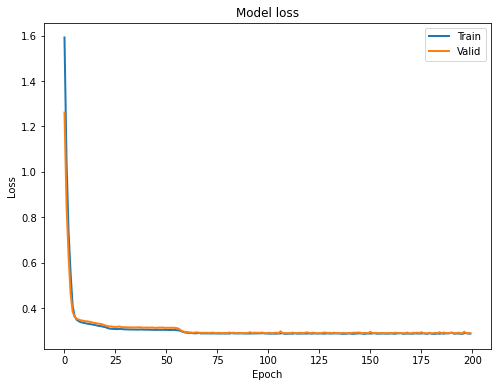

In [ ]:
from google.colab import files
train = plt.figure()
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
train.show()
train.savefig('trainae.png')
files.download('trainae.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reconstruction error threshold:  4.0169136868131705


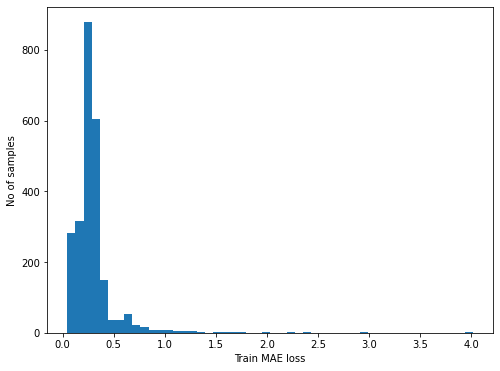

In [ ]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mae = np.mean(np.abs(df_valid_x_rescaled - valid_x_predictions), axis=1)
hist = plt.figure()
plt.hist(mae, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
hist.show()
hist.savefig('hist.png')
files.download('hist.png')
# Get reconstruction loss threshold.
threshold = np.max(mae)
print("Reconstruction error threshold: ", threshold)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

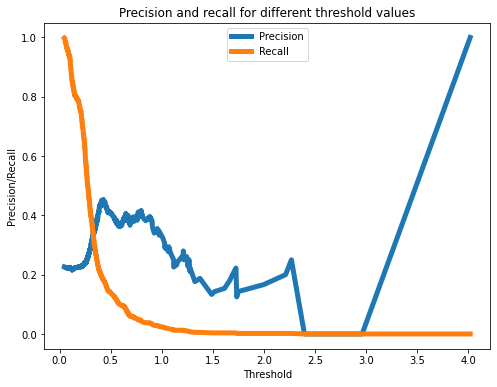

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mae,
                        'True_class': df_valid['class']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
p = plt.figure()
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
p.show()
p.savefig('P&Tae.png')
files.download('P&Tae.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 576x432 with 0 Axes>

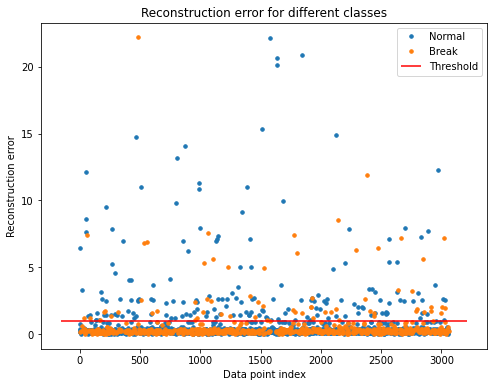

In [ ]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['class']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 1
groups = error_df_test.groupby('True_class')
pp = plt.figure()
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
pp.show();
pp.savefig('plotae.png')
files.download('plotae.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

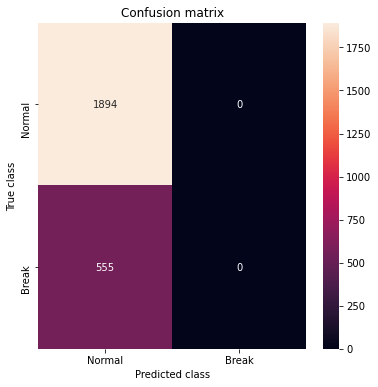

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
cm = plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
cm.show()
cm.savefig('matrixae.png')
files.download('matrixae.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

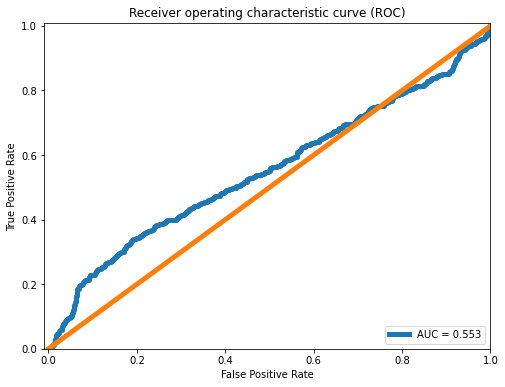

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
roc = plt.figure()
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
roc.show()
roc.savefig('ROCae.png')
files.download('ROCae.png')